In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random

from scipy.stats import foldnorm, norm
import matplotlib.pyplot as plt

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB


Data generation

In [188]:
rob_results_df = pd.DataFrame(columns=['p', 'BO1/BO2', 'BO3'])

for rob_counter in range(50):


    random.seed(rob_counter)

    #Define the number of elements in each set I, J, K
    i_num = 7
    k_num = 1
    j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num
    degree_to_m = 111111

    #Define empty data frames
    I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
    J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
    K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

    #Define sets of I, J, K, where J contains I and K

    for i in range(i_num):
        I.loc[i, 'Point number'] = 'i'+ str(i)
        I.loc[i, 'Latitude'] = round(random.uniform(0, 3000), 0)
        I.loc[i, 'Longitude'] = round(random.uniform(0, 3000), 0)

    I.index = I['Point number']


    for k in range(k_num):
        K.loc[k, 'Point number'] = 'k'+ str(k)
        K.loc[k, 'Latitude'] = round(random.uniform(0, 3000), 0)
        K.loc[k, 'Longitude'] = round(random.uniform(0, 3000), 0)

    K.index = K['Point number']


    for j in range(j_num):
        J.loc[j, 'Point number'] = 'j'+ str(j)
        J.loc[j, 'Latitude'] = round(random.uniform(0, 3000), 0)
        J.loc[j, 'Longitude'] = round(random.uniform(0, 3000), 0)

    J.index = J['Point number']
    J = pd.concat([J, K, I], axis = 0) #Include K to J
    J

    #Define constants

    B = 91800 #battery load: meters of travel
    S = 1020 #meters of service time
    W = 2500 #max grams of weight

    p = 0.9

    alpha = 15900 #euro

    beta = {}
    for j in J.index:
        if j.startswith('j'):
            beta[j] = 203000
        else:
            beta[j] = 76920

    gamma = 0.0045 / 1000 # variable cost in euro per m

    q_j = {}
    for j in J.index:
        if j.startswith('j'):
            q_j[j] = 255
        else:
            q_j[j] = 45



    softlimit = 200
    hardlimit = 600

    #Model termination function

    def softtime(model, where):
        if where == GRB.Callback.MIP:
            runtime = model.cbGet(GRB.Callback.RUNTIME)
            objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
            objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
            gap = abs((objbst - objbnd) / objbst)

            if runtime > softlimit and gap < 0.5:
                model.terminate()
                

    std_dev = {i : random.uniform(10000, 70000) for i in I.index}

    #Define random variable

    theta_ran_i = {}
    for i in list(I.index):
        theta_ran_i[i] = foldnorm(c=0, loc=0, scale=std_dev[i]) 
        
    #Define deterministic theta
    theta_det = {}
    for i in I.index:
        theta_det[i] = theta_ran_i[i].rvs(1)[0]
        
    r = len(theta_ran_i.keys()) #r-variate random vector theta


    #Define distance matrices

    def distance(point1, PointsSet1, point2, PointsSet2):
        c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
        c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
        return np.linalg.norm(c1-c2)

    dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
    dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
    dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}

    dist_KJ

    def ListSolution(model):
            nSolutions = model.SolCount
            print('Number of solutions found: ' + str(nSolutions))
            for e in range(nSolutions):
            #for iter2 in range(1):
                    model.setParam(GRB.Param.SolutionNumber, e)
                    print(e)
                    print('%g ' % model.PoolObjVal, end='\n')
                    for v in model.getVars():
                            if v.X > 0:
                                    print ('%s %g' % (v.varName, int(v.X)))
                                    #print(v)
                    print("\n")

            print("\n")


    def SolutionSummary(model):
        n = -1
        results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
        for opt_sol in range(1):
            for v in model.getVars():
                if v.varName.startswith('x_ikj'):
                    if v.X > 0:
                        n += 1
                        indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                        results.loc[n, 'i'] = indices[0]
                        results.loc[n, 'k'] = indices[1]
                        results.loc[n, 'j'] = indices[2]
                        results.loc[n, 'Number of drones'] = int(v.X)
        results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
        results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
        results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
        total_drones = sum(results['Number of drones'])
        total_locations = results['j'].nunique()
        return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


    #Redefine set L
    L = list()
    for k, j in itertools.product(K.index, J.index):
        if dist_KJ[(k, j)] <= B:
            L.append((k, j))

    L

    #Redefine set P
    P = list()
    for i, k in itertools.product(I.index, K.index):
        if dist_IK[(i, k)] <= B:
            P.append((i, k))

    P

    #Redefine sets M_kj

    M_kj = {}
    M_interim = []

    for (k, j) in L:
        for i in I.index:
            if dist_JI[j, i] <= S:
                if dist_JI[j, i] + dist_IK[i, k] <= B:
                    M_interim.append(i)
        M_kj[(k, j)] = M_interim
        M_interim = []

    M_kj_final = {key : val for key, val in M_kj.items() if val != []}

    KJ_feas = list(M_kj_final.keys())
    KJ_feas

    #Redefine sets N_i

    N_i = {}
    N_interim = []

    for i in I.index:
        for (k, j) in L:
            if dist_JI[j, i] <= S:
                if dist_JI[j, i] + dist_IK[i, k] <= B:
                    N_interim.append((k, j))
        N_i[i] = N_interim
        N_interim = []

    N_i_final = {key : val for key, val in N_i.items() if val != []}

    I_feas = list(N_i_final.keys())

    #Redefine sets O_j

    O_j = {}
    O_interim = []

    for j in J.index:
        for (i, k) in P:
            if dist_JI[j, i] <= S:
                if dist_JI[j, i] + dist_IK[i, k] <= B:
                    O_interim.append((i, k))
        O_j[j] = O_interim
        O_interim = []

    O_j_final = {key : val for key, val in O_j.items() if val != []}

    J_feas = list(O_j_final.keys())
    J_feas


    def AddBasisGurobi(model, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                                alpha, beta, gamma, hardlimit):

        #Adding basic variables x_ikj and y_j
        x_ikj = model.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
        y_j = model.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')


        #Adding constraints except for demand covering
        model.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'Capacity')
        model.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                    for i in I_feas for (k, j) in KJ_feas), name = 'Battery')
        model.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'Service time')
        model.addConstrs((y_j[k] == 1 for k in K.index), name = 'Open laboratories')

        #Set objective
        model.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

        #Set parameter TimeLimit
        model.setParam('TimeLimit', hardlimit)

        return x_ikj, y_j




    model_DM = gp.Model('DM')

    x_ikj, y_j = AddBasisGurobi(model_DM, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                                alpha, beta, gamma, hardlimit)

    #Add demand constraints
    model_DM.addConstrs((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'Demand')

    model_DM.optimize(softtime)



    model_BO2 = gp.Model('BO2')

    #model_BO1.Params.Presolve = 0

    x_ikj, y_j = AddBasisGurobi(model_BO2, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                                alpha, beta, gamma, hardlimit)

    z_i = model_BO2.addVars(I_feas, lb = 0, vtype = GRB.CONTINUOUS, name = 'z_i') #half-normally distributed variable
    F_i = model_BO2.addVars(I_feas, lb=0, ub=1, vtype = GRB.CONTINUOUS, name='F_i') #marginal distribution
    test_F_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_F_i') #because of rounding precision
    test_q_i = model_BO2.addVars(I_feas, vtype = GRB.CONTINUOUS, name='test_q_i') #because of rounding precision

    q_i = model_BO2.addVars(I_feas, lb=p, ub=1, vtype = GRB.CONTINUOUS, name='q_i') #auxiliary variable


    for i in I_feas:
        
        #Generate mapping z->cdf
        step = 0.005
        ones = [1] * 5
        foldnorm_cdf_values = []
        z_values = []
        foldnorm_cdf_values = np.round(np.arange(step, 1, step).tolist(), 3)
        z_values = foldnorm.ppf(foldnorm_cdf_values, c=0, loc = 0, scale=std_dev[i]).tolist()
        foldnorm_cdf_values = np.append(foldnorm_cdf_values, ones)
        
        for one in ones:
            z_values = np.append(z_values, z_values[-1]+50*one)
            
            
        
        model_BO2.addConstr(z_i[i] == gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]), name = 'Z-replacement')
        
        model_BO2.addGenConstrPWL(xvar=z_i[i], yvar=F_i[i], xpts=z_values, ypts=foldnorm_cdf_values, name="F_i=cdf(z_i)")
        
        model_BO2.addConstr(test_F_i[i] == F_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
        model_BO2.addConstr(test_q_i[i] == q_i[i] * 1000000) #test that F_i are not equal to 0 (because of rounding)
        
        model_BO2.addConstr((F_i[i] >= q_i[i]), name='Joint probabilistic constraint')
        

    model_BO2.addConstr(1 - p >= (gp.quicksum(1 - q_i[i] for i in I_feas)), name='Auxiliary constraint')

    model_BO2.update()

    model_BO2.optimize(softtime)


    #Generate mapping prob->quantile
    step = 0.005
    ones = [1] * 5
    z_values = []
    prob_values = []
    prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
    z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev['i0']).tolist()
    prob_values = np.append(prob_values, ones)

    for one in ones:
        z_values = np.append(z_values, z_values[-1]+50*one)
        
        
    model_BO3 = gp.Model('BO3')

    x_ikj, y_j = AddBasisGurobi(model_BO3, I, J, K, L, N_i_final, I_feas, KJ_feas, O_j_final, q_j, dist_JI, dist_IK, B, S,
                                alpha, beta, gamma, hardlimit)

    F_quant_i = model_BO3.addVars(I_feas, vtype = GRB.CONTINUOUS, name='F_quant_i')
    prob = model_BO3.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name='prob')


    model_BO3.addConstr((prob == 1-(1-p)/r), name = 'Prob replacement')


    for i in I_feas:
        
        step = 0.005
        ones = [1] * 5
        z_values = []
        prob_values = []
        prob_values = np.round(np.arange(step, 1, step).tolist(), 3)
        z_values = foldnorm.ppf(prob_values, c=0, loc = 0, scale=std_dev[i]).tolist()
        prob_values = np.append(prob_values, ones)

        for one in ones:
            z_values = np.append(z_values, z_values[-1]+50*one)
            
        
        model_BO3.addGenConstrPWL(xvar=prob, yvar=F_quant_i[i], xpts=prob_values, ypts=z_values, name="F1=ppf(prob)")
        
        model_BO3.addConstr((gp.quicksum(W * x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= F_quant_i[i]), name = 'Joint probabilistic constraint')

    model_BO3.update()

    model_BO3.optimize(softtime)




    def Robustness_Summary(model):
        n = -1
        results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
        for opt_sol in range(1):
            for v in model.getVars():
                if v.varName.startswith('x_ikj'):
                    if v.X > 0:
                        n += 1
                        indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                        results.loc[n, 'i'] = indices[0]
                        results.loc[n, 'k'] = indices[1]
                        results.loc[n, 'j'] = indices[2]
                        results.loc[n, 'Number of drones'] = int(v.X)
        results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
        #results_doctors['Prob Number of drones'] = results_doctors['Number of drones'].astype(int)
        return results_doctors


    def Robustness(model_PM):
        robustness_df = Robustness_Summary(model_PM)
        robustness_df['DM Number of drones'] = Robustness_Summary(model_DM)['Number of drones']

        # Calculate the difference between 'Number of drones' and 'DM Number of drones'
        difference = robustness_df['Number of drones'] - robustness_df['DM Number of drones']

        # Assign 'Drones uncovered' column based on the condition
        robustness_df['Drones uncovered'] = np.where(difference >= 0, 0, abs(difference))
        robustness = 1 - sum(robustness_df['Drones uncovered']) / sum(robustness_df['DM Number of drones'])
        return robustness


    rob_results_df.loc[rob_counter, 'p'] = p
    rob_results_df.loc[rob_counter, 'BO1/BO2'] = Robustness(model_BO2)
    rob_results_df.loc[rob_counter, 'BO3'] = Robustness(model_BO3)
    
    
rob_results_df

Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1538 rows, 864 columns and 2027 nonzeros
Model fingerprint: 0x8dd830de
Variable types: 0 continuous, 864 integer (108 binary)
Coefficient statistics:
  Matrix range     [5e-01, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 2075140.7467
Presolve removed 1450 rows and 650 columns
Presolve time: 0.00s
Presolved: 88 rows, 214 columns, 344 nonzeros
Found heuristic solution: objective 1669140.6977
Variable types: 0 continuous, 214 integer (84 binary)
Found heuristic solution: objective 1669140.6967

Root relaxation: objective 1.137061e+06, 104 iterations, 0.00 seconds (0.00 work unit

,p,BO1/BO2,BO3
0,0.9,1.0,1.0
1,0.9,0.988235,1.0
2,0.9,1.0,1.0
3,0.9,1.0,1.0
4,0.9,0.87156,0.880734
5,0.9,1.0,1.0
6,0.9,1.0,1.0
7,0.9,1.0,1.0
8,0.9,1.0,1.0
9,0.9,0.989247,1.0


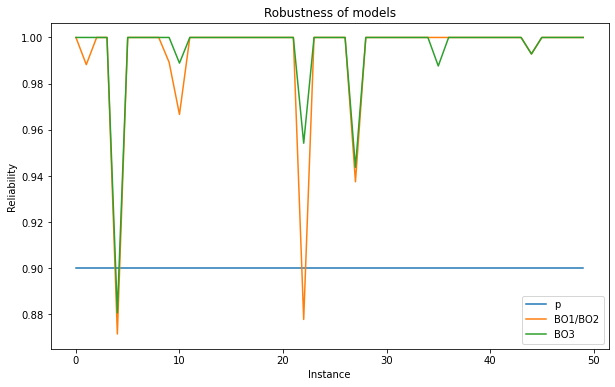

In [193]:
plt.figure(figsize=(10, 6))

plt.plot(rob_results_df.index, rob_results_df['p'], label='p')
plt.plot(rob_results_df.index, rob_results_df['BO1/BO2'], label='BO1/BO2')
plt.plot(rob_results_df.index, rob_results_df['BO3'], label='BO3')

# Add labels and title
plt.xlabel('Instance')
plt.ylabel('Reliability')
plt.title('Robustness of models')

# Add legend
plt.legend()

# Show the plot
plt.show()